In [53]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import sklearn as sk
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [47, 8]

data = sio.loadmat('all_cell_dF.mat')
data = data['all_cell_dF']
mean_data = np.nanmean(data,axis=1)

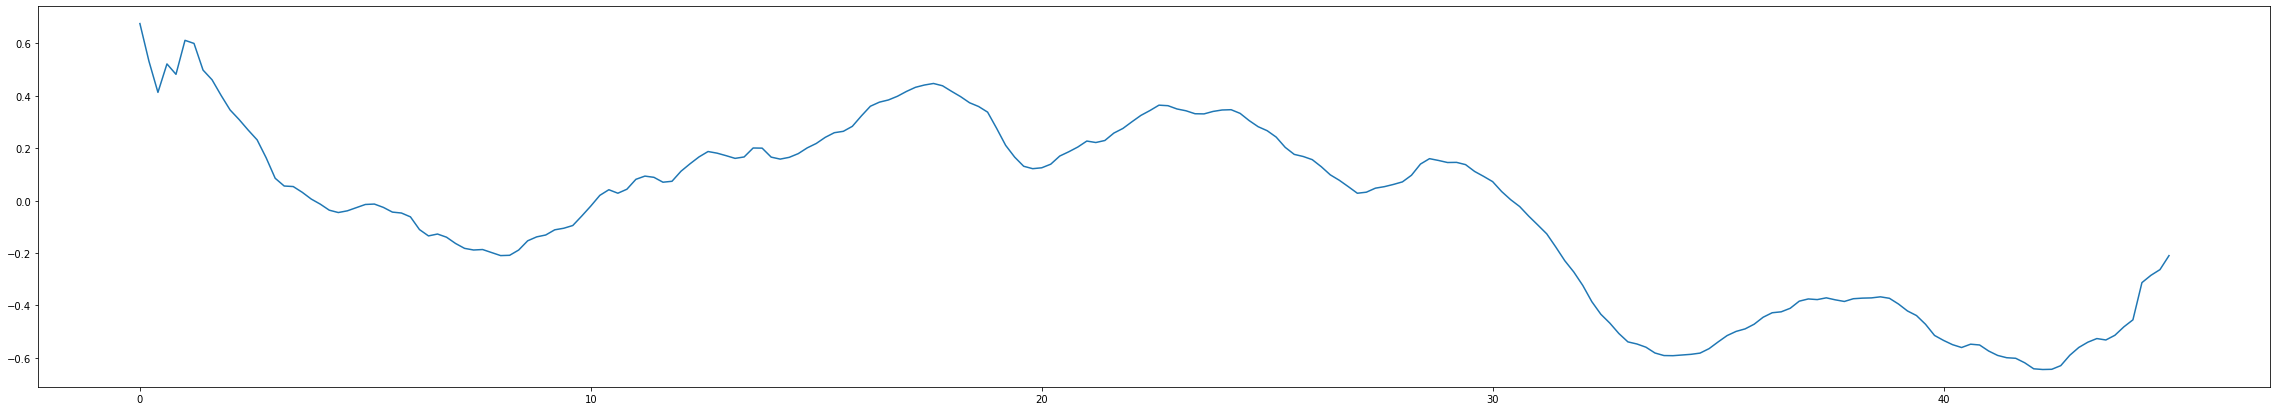

In [54]:
plt.rcParams['figure.figsize'] = [40, 7]
x = np.linspace(0,45,mean_data[93].shape[0])
plt.plot(x,mean_data[93])

In [55]:
#change this value if you want to increase/decrease number of values around peak to be included
window = 40

def extract_peaks(data,window=40):
    result_subarr = np.ndarray(shape=(len(data),window*2), dtype=float)
    result_peak_idx = []
    for i,elem in enumerate(data):
        loc = np.where(elem==max(elem[window:]))[0][0]
        result_subarr[i]=elem[loc-window:loc+window]
        result_peak_idx.append(loc)
    return result_subarr,result_peak_idx
peak_data,peak_idx = extract_peaks(mean_data,window=window)

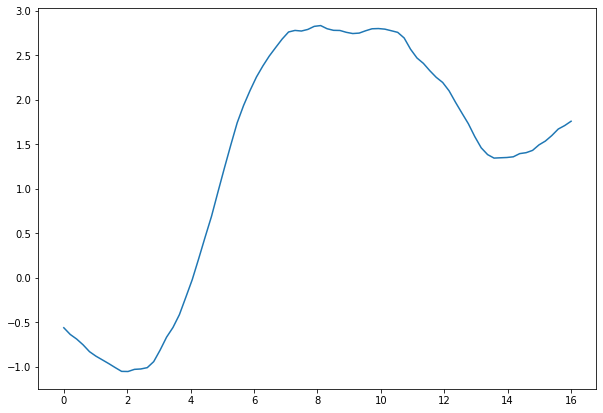

In [56]:
plt.rcParams['figure.figsize'] = [10, 7]
x = np.linspace(0,0.2*2*window,2*window)
plt.plot(x,peak_data[18])

In [57]:
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(peak_data)

pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

In [58]:
def k_means(data, num_clus=2, steps=200):

    # Convert data to Numpy array
    cluster_data = np.array(data)

    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))

            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())

    return cluster, center_init, distance

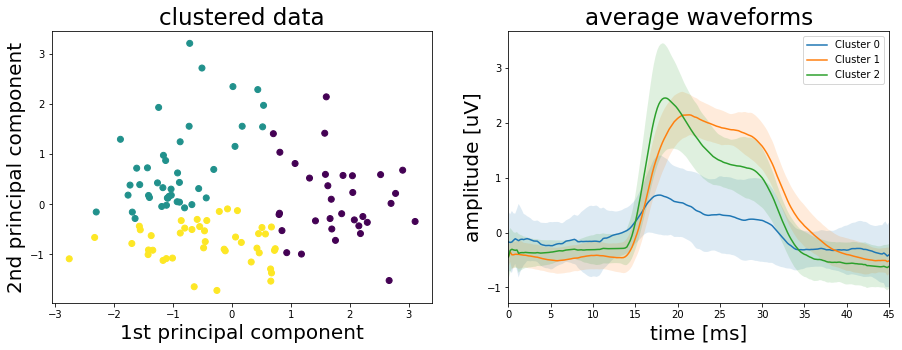

In [59]:
num_clus = 3
wave_form=mean_data
sf = len(wave_form)
cluster, centers, distance = k_means(pca_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

time = np.linspace(0, 45, wave_form.shape[1])
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)

    ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.savefig('PCA-dots.png')
plt.show()

In [60]:
#indices
cluster

array([2, 0, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 2, 0,
       1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1], dtype=int64)

In [61]:
def plot_data_pca(data,cluster,num_clust,filenamesave="PCA"):
    fig, axs = plt.subplots(1, num_clust)
    axs = axs.tolist()
    t = np.linspace(0,45,226)

    for el in axs:
        el.set_xlim([0,45])
        el.set_xlabel("Time (sec)")
        el.xaxis.set_major_locator(plt.MaxNLocator(5))
        el.set_ylim([-2,40])
        el.yaxis.set_visible(False)
    toavgaxs = []
    plots = []
    for i in range(num_clust):
        toavgaxs.append([]);
        plots.append([]);
    
    for idx,el in enumerate(mean_data):
        toavgaxs[cluster[idx]].append(el)
        if cluster[idx]==1:
            plots[0].append(el)
        elif cluster[idx]==0:
            plots[1].append(el)
        else:
            plots[2].append(el)
        
    for idx,el in enumerate(plots[0]):
        diff = el[0]
        el = [elm - diff + idx*0.5 for elm in el] 
        axs[1].plot(t,el,'black')
    for idx,el in enumerate(plots[1]):
        diff = el[0]
        el = [elm - diff + idx*0.5 for elm in el] 
        axs[0].plot(t,el,'red')
    if(len(plots)==3):
        for idx,el in enumerate(plots[2]):
            diff = el[0]
            el = [elm - diff + idx*0.5 for elm in el] 
            axs[2].plot(t,el,'cyan')
    axs[1].plot([5,5],[33,38],'r')
    axs[1].text(7,32.5,'5 dF/F')
    plt.savefig(f'{filenamesave}.png')

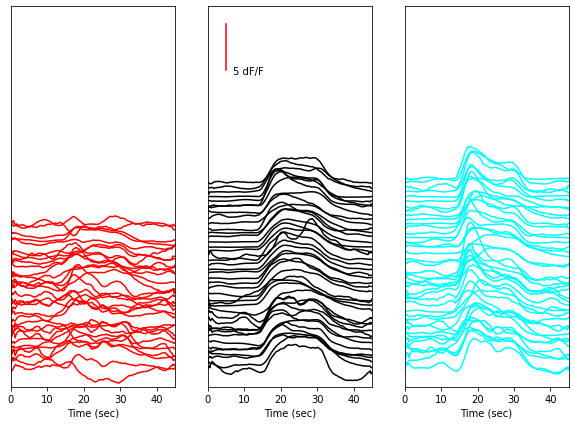

In [62]:
plot_data_pca(mean_data,cluster,num_clus,filenamesave="test")

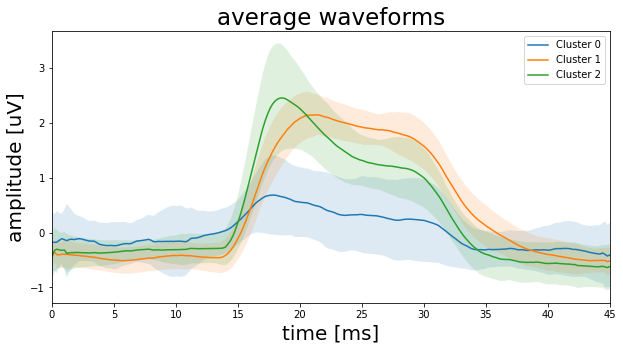

In [63]:
fig, (ax) = plt.subplots(1, 1, figsize=(10, 5))

time = np.linspace(0, 45, wave_form.shape[1])
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)

    ax.plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax.fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax.set_title('average waveforms', fontsize=23)
ax.set_xlim([0, time[-1]])
ax.set_xlabel('time [ms]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.savefig('PCA-mean+SEM.png')
plt.show()